###   Importing necessary library

In [1]:
import os

import tensorflow as tf

from typing import List
import numpy as np
from PIL import Image
import time
import sys
from threading import Thread

In [2]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

In [3]:
from collections import Counter
from typing import List, Tuple

In [4]:
from six import iteritems, string_types
from matplotlib import pyplot as plt

In [5]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [6]:
import pickle as pk

In [7]:
FACE_PIC_SIZE = 160

EMBEDDING_SIZE = 512

PRETREINED_MODEL_DIR = os.path.join(os.getcwd(),'pretrained_models')

UNKNOWN_CLASS = "Mr Nobody"

CLUSTER = "_embeddings.SVC"

CLASSIFIER = "CLASSIFIER"

CLASSIFY_NAME = 'SVM.SVC'

SGD_CLASSIFY = 'SGD.CLASS'

GPC_CLASSIFY = 'GPC.CLASS'

CELEB_EMB = 'cleb_emb'

CELEB_DATASET = 'celeb_dataset'

In [8]:
PRETREINED_MODEL_DIR

'F:\\MLTUT\\pretrained_models'

In [9]:
import cv2

### Implementation of Layers

In [10]:
padding = ['SAME','VALID']

In [11]:
def load(data_path, session, ignore_missing=False):
    """Load network weights.
    @data_path: The path to the numpy-serialized network weights
    @session: The current TensorFlow session
    @ignore_missing: If true, serialized weights for missing layers are ignored.
    """
    data_dict = np.load(data_path, encoding='latin1').item()  # pylint: disable=no-member

    for op_name in data_dict:
        with tf.variable_scope(op_name, reuse=True):
            for param_name, data in iteritems(data_dict[op_name]):
                try:
                    var = tf.get_variable(param_name)
                    session.run(var.assign(data))
                except ValueError:
                    if not ignore_missing:
                        raise

In [12]:
def conv(inpt, k_h, k_w, c_o, s_h, s_w, name, relu=True, padding=padding[0], biased=True):
    """
    @inpt: input data to convolve
    @k_h: kernel height  
    @k_w: kernel width
    @c_o: number of filter
    @s_h: strides weight
    @s_w: strides height 
    @name: layer name
    @relu: non linearity RELU
    @padding: filter padding 
    """
# Get the number of channels in the input
    c_i = int(inpt.get_shape()[-1])

    # Convolution for a given input and kernel
    with tf.variable_scope(name) as scope:
        kernel = tf.get_variable('weights', shape=[k_h, k_w, c_i, c_o], trainable=True)
        
        output = tf.nn.conv2d(inpt, kernel, [1, s_h, s_w, 1], padding=padding)
        # Add the biases
        if biased:
            biases = tf.get_variable('biases', [c_o])
            output = tf.nn.bias_add(output, biases)
        if relu:
            # ReLU non-linearity
            output = tf.nn.relu(output, name=scope.name)
        return output

In [13]:
def prelu(inpt, name):
    """
    @inpt: input from previous layer
    @name: layer name
    """
    with tf.variable_scope(name):
        i = int(inpt.get_shape()[-1])
        alpha = tf.get_variable('alpha', shape=(i,))
        output = tf.nn.relu(inpt) + tf.multiply(alpha, -tf.nn.relu(-inpt))
    return output

In [14]:
def max_pool(inpt, k_h, k_w, s_h, s_w, name, padding=padding[0]):
    """
    @inpt: input from previous layer
    @k_h: kernel height
    @k_w: kernel width
    @s_h: stride height
    @s_w: stride width
    @name: layer name
    @padding: Valid Padding ['SAME','VALID']
    """
    return tf.nn.max_pool(inpt, ksize=[1, k_h, k_w, 1],strides=[1, s_h, s_w, 1], padding=padding, name=name)

In [15]:
def fully_connected(inpt, num_out, name, relu=True):
    """
    @inpt: input from previous layer
    @num_out: output layer
    """
    with tf.variable_scope(name):
        input_shape = inpt.get_shape()
        if input_shape.ndims == 4:
            # since the input is spatial.we have to Vectorize it first.
            dim = 1
            for d in input_shape[1:].as_list():
                dim *= int(d)
            feed_in = tf.reshape(inpt, [-1, dim])
        else:
            feed_in, dim = (inpt, input_shape[-1].value)
        weights = tf.get_variable('weights', shape=[dim, num_out])
        biases = tf.get_variable('biases', [num_out])
        op = tf.nn.relu_layer if relu else tf.nn.xw_plus_b
        fc = op(feed_in, weights, biases, name=name)
        return fc

In [16]:
def softmax(target, axis, name=None):
    """
    @target: target layer to apply softmax
    @axis: axes to apply softmax
    @name: layer name
    """
    max_axis = tf.reduce_max(target, axis, keepdims=True)
    target_exp = tf.exp(target - max_axis)
    normalize = tf.reduce_sum(target_exp, axis, keepdims=True)
    softmax = tf.div(target_exp, normalize, name)
    return softmax

## Implementation of MTCNN

### P-Net ( Proposal - Network )

In [17]:
def pNet(data):
    value = conv(data, 3, 3, 10, 1, 1, padding='VALID', relu=False, name='conv1')
    value = prelu(value, name='PReLU1')
    value = max_pool(value, 2, 2, 2, 2, name='pool1')
    value = conv(value ,3, 3, 16, 1, 1, padding='VALID', relu=False, name='conv2')
    value = prelu(value ,name='PReLU2')
    value = conv(value ,3, 3, 32, 1, 1, padding='VALID', relu=False, name='conv3')
    value = prelu(value ,name='PReLU3')
#     Face detection classfication probablity output
    val_conv4_1 = conv(value ,1, 1, 2, 1, 1, relu=False, name='conv4-1')
    classify = softmax(val_conv4_1 ,3, name='prob1')
#     bounding box regression
    bbr = conv(value ,1, 1, 4, 1, 1, relu=False, name='conv4-2')
    
    return(classify, bbr)

### R-Net ( Refinement - Network )

In [18]:
def rNet(data):
    value = conv(data, 3, 3, 28, 1, 1, padding='VALID', relu=False, name='conv1')
    value = prelu(value, name='prelu1')
    value = max_pool(value, 3, 3, 2, 2, name='pool1')
    value = conv(value, 3, 3, 48, 1, 1, padding='VALID', relu=False, name='conv2')
    value = prelu(value, name='prelu2')
    value = max_pool(value, 3, 3, 2, 2, padding='VALID', name='pool2')
    value = conv(value, 2, 2, 64, 1, 1, padding='VALID', relu=False, name='conv3')
    value = prelu(value, name='prelu3')
    value = fully_connected(value, 128, relu=False, name='conv4')
    value = prelu(value, name='prelu4')
#     face detection classfication probablity output
    conv5_1 = fully_connected(value, 2, relu=False, name='conv5-1')
    classify = softmax(conv5_1, 1, name='prob1')
#     bounding box regression
    bbr = fully_connected(value,4, relu=False, name='conv5-2')
    
    return (classify, bbr)

### O-Net ( Output - Network )  

In [19]:
def oNet(data):
    value = conv(data, 3, 3, 32, 1, 1, padding='VALID', relu=False, name='conv1')
    value = prelu(value, name='prelu1')
    value = max_pool(value ,3, 3, 2, 2, name='pool1')
    value = conv(value, 3, 3, 64, 1, 1, padding='VALID', relu=False, name='conv2')
    value = prelu(value, name='prelu2')
    value = max_pool(value, 3, 3, 2, 2, padding='VALID', name='pool2')
    value = conv(value, 3, 3, 64, 1, 1, padding='VALID', relu=False, name='conv3')
    value = prelu(value, name='prelu3')
    value = max_pool(value, 2, 2, 2, 2, name='pool3')
    value = conv(value, 2, 2, 128, 1, 1, padding='VALID', relu=False, name='conv4')
    value = prelu(value, name='prelu4')
    value = fully_connected(value, 256, relu=False, name='conv5')
    value = prelu(value, name='prelu5')
#     face detection classification
    conv6_1 = fully_connected(value, 2, relu=False, name='conv6-1')
    classify = softmax(conv6_1, 1, name='prob1')
#     bounding box regression
    bbr = fully_connected(value, 4, relu=False, name='conv6-2')
    
#     face localization
    floc = fully_connected(value, 10, relu=False, name='conv6-3')
    
    return (classify, bbr, floc)

### Creating MTCNN Architecture

In [20]:
def create_mtcnn(sess, model_path):
    """
    Input @sess: Current session,
    Input @model_path: path of weights of model to load,
    """
#     Creating variable scope for Pnet
    with tf.variable_scope('pnet'):
        data = tf.placeholder(tf.float32, (None, None, None, 3), 'input')
        pnet = pNet(data)
        load(os.path.join(model_path, 'det1.npy'), sess)
        
#     Creating Variabel scope for Rnet
    with tf.variable_scope('rnet'):
        data = tf.placeholder(tf.float32, (None, 24, 24, 3), 'input')
        rnet = rNet(data)
        load(os.path.join(model_path, 'det2.npy'), sess)
        
#    Creating Variable scope for Onet
    with tf.variable_scope('onet'):
        data = tf.placeholder(tf.float32, (None, 48, 48, 3), 'input')
        onet = oNet(data)
        load(os.path.join(model_path, 'det3.npy'), sess)
        
#         Predicting facial features by cascading P-net, R-net and O-net
    pnet_fun = lambda img: sess.run(('pnet/conv4-2/BiasAdd:0', 'pnet/prob1:0'), feed_dict={'pnet/input:0': img})
    rnet_fun = lambda img: sess.run(('rnet/conv5-2/conv5-2:0', 'rnet/prob1:0'), feed_dict={'rnet/input:0': img})
    onet_fun = lambda img: sess.run(('onet/conv6-2/conv6-2:0', 'onet/conv6-3/conv6-3:0', 'onet/prob1:0'), feed_dict={'onet/input:0': img})
    
    return pnet_fun, rnet_fun, onet_fun

In [21]:
def _setup_mtcnn():
    with tf.Graph().as_default():
        sess = tf.Session()
        with sess.as_default():
            return create_mtcnn(sess, PRETREINED_MODEL_DIR)

### Generating MTCNN Graph

In [22]:
pnet, rnet, onet = _setup_mtcnn()

### Image Preprocessing and Scale Space Representation Algorithm

In [23]:
def detect_face(img, minsize, pnet, rnet, onet, threshold, factor):
    """Detects faces in an image, and returns bounding boxes and points for them.
    @img: input image
    @minsize: minimum faces' size
    @pnet, rnet, onet: proposal net, Refinement net, Output net
    @threshold: threshold=[th1, th2, th3], th1-3 are three steps's threshold
    @factor: the factor used to create a scaling pyramid of face sizes to detect in the image.
    """
    factor_count = 0
    total_boxes = np.empty((0, 9))
    points = np.empty(0)
    h = img.shape[0]
    w = img.shape[1]
    minl = np.amin([h, w])
    m = 12.0 / minsize
    minl = minl * m
    # create scale pyramid
    scales = []
    while minl >= 12:
        scales += [m * np.power(factor, factor_count)]
        minl = minl * factor
        factor_count += 1

    # first stage
    # Using P - Net to detect all probablistic faces and bounding boxes
    for scale in scales:
        hs = int(np.ceil(h * scale))
        ws = int(np.ceil(w * scale))
        im_data = imresample(img, (hs, ws))
        im_data = (im_data - 127.5) * 0.0078125
        img_x = np.expand_dims(im_data, 0)
        img_y = np.transpose(img_x, (0, 2, 1, 3))
        out = pnet(img_y)
        
        out0 = np.transpose(out[0], (0, 2, 1, 3))
        out1 = np.transpose(out[1], (0, 2, 1, 3))

        boxes, _ = generateBoundingBox(out1[0, :, :, 1].copy(), out0[0, :, :, :].copy(), scale, threshold[0])

        # Applying  Non-Maximum supression to supresses overlapping bounding box areas
        pick = nms(boxes.copy(), 0.5, 'Union')
        if boxes.size > 0 and pick.size > 0:
            boxes = boxes[pick, :]
            total_boxes = np.append(total_boxes, boxes, axis=0)

    numbox = total_boxes.shape[0]
    if numbox > 0:
        pick = nms(total_boxes.copy(), 0.7, 'Union')
        total_boxes = total_boxes[pick, :]
        regw = total_boxes[:, 2] - total_boxes[:, 0]
        regh = total_boxes[:, 3] - total_boxes[:, 1]
        qq1 = total_boxes[:, 0] + total_boxes[:, 5] * regw
        qq2 = total_boxes[:, 1] + total_boxes[:, 6] * regh
        qq3 = total_boxes[:, 2] + total_boxes[:, 7] * regw
        qq4 = total_boxes[:, 3] + total_boxes[:, 8] * regh
        total_boxes = np.transpose(np.vstack([qq1, qq2, qq3, qq4, total_boxes[:, 4]]))
        total_boxes = rerec(total_boxes.copy())
        total_boxes[:, 0:4] = np.fix(total_boxes[:, 0:4]).astype(np.int32)
        dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph = pad(total_boxes.copy(), w, h)

    numbox = total_boxes.shape[0]
    if numbox > 0:
        # second stage
        # Second stage of face detection 
        tempimg = np.zeros((24, 24, 3, numbox))
        for k in range(0, numbox):
            tmp = np.zeros((int(tmph[k]), int(tmpw[k]), 3))
            tmp[dy[k] - 1:edy[k], dx[k] - 1:edx[k], :] = img[y[k] - 1:ey[k], x[k] - 1:ex[k], :]
            if tmp.shape[0] > 0 and tmp.shape[1] > 0 or tmp.shape[0] == 0 and tmp.shape[1] == 0:
                tempimg[:, :, :, k] = imresample(tmp, (24, 24))
            else:
                return np.empty()
        tempimg = (tempimg - 127.5) * 0.0078125
        tempimg1 = np.transpose(tempimg, (3, 1, 0, 2))
        out = rnet(tempimg1)
        out0 = np.transpose(out[0])
        out1 = np.transpose(out[1])
        score = out1[1, :]
        ipass = np.where(score > threshold[1])
        total_boxes = np.hstack([total_boxes[ipass[0], 0:4].copy(), np.expand_dims(score[ipass].copy(), 1)])
        mv = out0[:, ipass[0]]
        if total_boxes.shape[0] > 0:
            pick = nms(total_boxes, 0.7, 'Union')
            total_boxes = total_boxes[pick, :]
            total_boxes = bbreg(total_boxes.copy(), np.transpose(mv[:, pick]))
            total_boxes = rerec(total_boxes.copy())

    numbox = total_boxes.shape[0]
    if numbox > 0:
        # third stage
        total_boxes = np.fix(total_boxes).astype(np.int32)
        dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph = pad(total_boxes.copy(), w, h)
        tempimg = np.zeros((48, 48, 3, numbox))
        for k in range(0, numbox):
            tmp = np.zeros((int(tmph[k]), int(tmpw[k]), 3))
            tmp[dy[k] - 1:edy[k], dx[k] - 1:edx[k], :] = img[y[k] - 1:ey[k], x[k] - 1:ex[k], :]
            if tmp.shape[0] > 0 and tmp.shape[1] > 0 or tmp.shape[0] == 0 and tmp.shape[1] == 0:
                tempimg[:, :, :, k] = imresample(tmp, (48, 48))
            else:
                return np.empty()
        tempimg = (tempimg - 127.5) * 0.0078125
        tempimg1 = np.transpose(tempimg, (3, 1, 0, 2))
        out = onet(tempimg1)
        out0 = np.transpose(out[0])
        out1 = np.transpose(out[1])
        out2 = np.transpose(out[2])
        score = out2[1, :]
        points = out1
        ipass = np.where(score > threshold[2])
        points = points[:, ipass[0]]
        total_boxes = np.hstack([total_boxes[ipass[0], 0:4].copy(), np.expand_dims(score[ipass].copy(), 1)])
        mv = out0[:, ipass[0]]

        w = total_boxes[:, 2] - total_boxes[:, 0] + 1
        h = total_boxes[:, 3] - total_boxes[:, 1] + 1
        points[0:5, :] = np.tile(w, (5, 1)) * points[0:5, :] + np.tile(total_boxes[:, 0], (5, 1)) - 1
        points[5:10, :] = np.tile(h, (5, 1)) * points[5:10, :] + np.tile(total_boxes[:, 1], (5, 1)) - 1
        if total_boxes.shape[0] > 0:
            total_boxes = bbreg(total_boxes.copy(), np.transpose(mv))
            pick = nms(total_boxes.copy(), 0.7, 'Min')
            total_boxes = total_boxes[pick, :]
            points = points[:, pick]

    return total_boxes, points

### Creating Bounding Box with coords given 

In [24]:
def generateBoundingBox(inp, reg, scale, t):
    """Use heatmap to generate bounding boxes
    @inp: Bounding box regerssion ( Probablistic )
    @scale: scale factor 
    @t: Threashold
    """
    stride = 2
    cellsize = 12

    imap = np.transpose(inp)
    dx1 = np.transpose(reg[:, :, 0])
    dy1 = np.transpose(reg[:, :, 1])
    dx2 = np.transpose(reg[:, :, 2])
    dy2 = np.transpose(reg[:, :, 3])
    y, x = np.where(imap >= t)
    if y.shape[0] == 1:
        dx1 = np.flipud(dx1)
        dy1 = np.flipud(dy1)
        dx2 = np.flipud(dx2)
        dy2 = np.flipud(dy2)
    score = imap[(y, x)]
    reg = np.transpose(np.vstack([dx1[(y, x)], dy1[(y, x)], dx2[(y, x)], dy2[(y, x)]]))
    if reg.size == 0:
        reg = np.empty((0, 3))
    bb = np.transpose(np.vstack([y, x]))
    q1 = np.fix((stride * bb + 1) / scale)
    q2 = np.fix((stride * bb + cellsize - 1 + 1) / scale)
    boundingbox = np.hstack([q1, q2, np.expand_dims(score, 1), reg])
    return boundingbox, reg

### Correction of Bounding box 

In [25]:
def bbreg(boundingbox, reg):
    """Calibrate bounding boxes"""
    if reg.shape[1] == 1:
        reg = np.reshape(reg, (reg.shape[2], reg.shape[3]))

    w = boundingbox[:, 2] - boundingbox[:, 0] + 1
    h = boundingbox[:, 3] - boundingbox[:, 1] + 1
    b1 = boundingbox[:, 0] + reg[:, 0] * w
    b2 = boundingbox[:, 1] + reg[:, 1] * h
    b3 = boundingbox[:, 2] + reg[:, 2] * w
    b4 = boundingbox[:, 3] + reg[:, 3] * h
    boundingbox[:, 0:4] = np.transpose(np.vstack([b1, b2, b3, b4]))
    return boundingbox

### Non Maximum supression Algorithem

In [26]:
# Non - Maximum supression technique
def nms(boxes, threshold, method):
#     if no face detected
    if boxes.size == 0:
        return np.empty((0, 3))
#     grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    s = boxes[:, 4]
#     initialize the list of picked indexes
    pick = np.zeros_like(s, dtype=np.int16)
#     compute the area of the bounding boxes and sort the bounding
#     boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    I = np.argsort(s)
    counter = 0
#     keep looping while some indexes still remain in the indexes
#     list
    while I.size > 0:
#         grab the last index in the indexes list, add the index
#         value to the list of picked indexes, then initialize
#         the suppression list (i.e. indexes that will be deleted)
#         using the last index
        i = I[-1]
        pick[counter] = i
        counter += 1
        idx = I[0:-1]
#         find the largest (x, y) coordinates for the start of
#         the bounding box and the smallest (x, y) coordinates
#         for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idx])
        yy1 = np.maximum(y1[i], y1[idx])
        xx2 = np.minimum(x2[i], x2[idx])
        yy2 = np.minimum(y2[i], y2[idx])
#         compute the widht and height of bounding box
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
#         compute the ratio of overlap between the computed
#         bounding box and the bounding box in the area list
        inter = w * h
        if method is 'Min':
            o = inter / np.minimum(area[i], area[idx])
        else:
            o = inter / (area[i] + area[idx] - inter)
#         if there is sufficient overlap, suppress the
#         current bounding box
#             delete all indexes from the index list that are in the
#             suppression list
        I = I[np.where(o <= threshold)]
#     return only the bounding boxes that were picked
    pick = pick[0:counter]
    return pick

In [27]:
def pad(total_boxes, w, h):
    """
    Compute the padding coordinates (pad the bounding boxes to square)
    @total_boxes: detected boxes for face
    @w: width of image
    @h: height of image
    """
    tmpw = (total_boxes[:, 2] - total_boxes[:, 0] + 1).astype(np.int32)
    tmph = (total_boxes[:, 3] - total_boxes[:, 1] + 1).astype(np.int32)
    numbox = total_boxes.shape[0]

    dx = np.ones((numbox), dtype=np.int32)
    dy = np.ones((numbox), dtype=np.int32)
    edx = tmpw.copy().astype(np.int32)
    edy = tmph.copy().astype(np.int32)

    x = total_boxes[:, 0].copy().astype(np.int32)
    y = total_boxes[:, 1].copy().astype(np.int32)
    ex = total_boxes[:, 2].copy().astype(np.int32)
    ey = total_boxes[:, 3].copy().astype(np.int32)

    tmp = np.where(ex > w)
    edx.flat[tmp] = np.expand_dims(-ex[tmp] + w + tmpw[tmp], 1)
    ex[tmp] = w

    tmp = np.where(ey > h)
    edy.flat[tmp] = np.expand_dims(-ey[tmp] + h + tmph[tmp], 1)
    ey[tmp] = h

    tmp = np.where(x < 1)
    dx.flat[tmp] = np.expand_dims(2 - x[tmp], 1)
    x[tmp] = 1

    tmp = np.where(y < 1)
    dy.flat[tmp] = np.expand_dims(2 - y[tmp], 1)
    y[tmp] = 1

    return dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph

In [28]:
def rerec(bboxA):
    """Convert bounding box to square."""
    h = bboxA[:, 3] - bboxA[:, 1]
    w = bboxA[:, 2] - bboxA[:, 0]
    l = np.maximum(w, h)
    bboxA[:, 0] = bboxA[:, 0] + w * 0.5 - l * 0.5
    bboxA[:, 1] = bboxA[:, 1] + h * 0.5 - l * 0.5
    bboxA[:, 2:4] = bboxA[:, 0:2] + np.transpose(np.tile(l, (2, 1)))
    return bboxA


def imresample(img, sz):
    im_data = cv2.resize(img, (sz[1], sz[0]), interpolation=cv2.INTER_AREA)
    return im_data

### Class for face embeddings

In [29]:
class Face:
    # face bounding boxes
    def __init__(self, x, y, w, h, confidence, img):
        """
        @x: boundind box location x
        @y: bounding box location y
        @w: bounding box width
        @h: bounding box height
        @confidence: face detection confidence level
        @img: array image
        """
        self.img = img
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.confidence = confidence

        self.predict_proba = None
        self.predict_candidates = None
        self.predict_candidates_proba = None

    def data(self):
        return { k:v for k, v in self.__dict__.items() if k != 'img'}

### Image object to numpy array

In [30]:
def img_to_np(image):
    """ 
    Image to numpy array
    """
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

### Face detection embeddings

In [72]:
def get_faces(image, threshold=0.5, minsize=20):
    """
    @image: video frame
    @threshold: threshold to detect face
    """
    img = img_to_np(image)
    # face detection parameters
    threshold = [0.6, 0.8, 0.88]  # three steps's threshold
    factor = 0.68  # scale factor
    faces = []

    bounding_boxes, _ = detect_face(img, minsize, pnet, rnet, onet,
                                                      threshold, factor)
    for bb in bounding_boxes:
        img = image.crop(bb[:4])
        bb[2:4] -= bb[:2]
        faces.append(Face(*bb, img))

    return faces

### Face Recognition

#### Using Pre-trained Inception-V3 Network Model

In [32]:
MODEL_FILE_NAME = os.path.join('20180402-114759','20180402-114759.pb')
MODEL_FILE_NAME

'20180402-114759\\20180402-114759.pb'

#### Loading pre - trained model

In [33]:
sess = None
def load_model(pb_file, input_map=None):
    global sess
    if sess is None:
        sess = tf.Session()
        print('Model filename: %s' % pb_file)
        with tf.gfile.GFile(pb_file, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            tf.import_graph_def(graph_def, input_map=input_map, name='')


load_model(os.path.join(PRETREINED_MODEL_DIR, MODEL_FILE_NAME))

Model filename: F:\MLTUT\pretrained_models\20180402-114759\20180402-114759.pb


In [34]:
# inception net requires this
def prewhiten(x):
    mean = np.mean(x)
    std = np.std(x)
    std_adj = np.maximum(std, 1.0 / np.sqrt(x.size))
    y = np.multiply(np.subtract(x, mean), 1 / std_adj)
    return y

In [35]:
def embedding(face_np):
    """
    @face_np: cropped image as input
    @name: image name
    """
    global sess
#     input place holder and  embeddings 
    images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
    embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
    phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
    x = prewhiten(face_np)
    feed_dict = {images_placeholder: [x], phase_train_placeholder: False}
    result = sess.run(embeddings, feed_dict=feed_dict)[0]
    return result

def input_shape():
    return tf.get_default_graph().get_tensor_by_name("input:0").get_shape()


def embedding_size():
    return tf.get_default_graph().get_tensor_by_name("embeddings:0").get_shape()[1]

###  KNN classifier

In [36]:
class KNN:
    def __init__(self, K=4, dist_threshold=12):
        
#         current training data
        self.X_train = None
        self.y_train = None
        self.idx_to_lbl = None
        self.lbl_to_idx = None
        self.y_train_idx = None

#         important params for classification
        self.dist_threshold_value = dist_threshold
        self.K = K

#         placeholders for input feed
        self.xtr = tf.placeholder(tf.float32, [None, EMBEDDING_SIZE], name='X_train')
        self.ytr = tf.placeholder(tf.float32, [None], name='y_train')
        self.xte = tf.placeholder(tf.float32, [EMBEDDING_SIZE], name='x_test')
        self.dist_threshold = tf.placeholder(tf.float32, shape=(), name="dist_threshold")
#         self.K  = tf.placeholder(tf.int32,shape=(),name="k_NN")
#         Building Model

#         model
        distance = tf.reduce_sum(tf.abs(tf.subtract(self.xtr, self.xte)), axis=1)
        values, indices = tf.nn.top_k(tf.negative(distance), k=self.K, sorted=False, name="nn_topk")
        nn_dist = tf.negative(values)
        self.valid_nn_num = tf.reduce_sum(tf.cast(nn_dist < self.dist_threshold, tf.float32))
        nn = []
        for i in range(0,self.K):
            nn.append(self.ytr[indices[i]])  # taking the result indexes

#         saving list in tensor variable 
        nearest_neighbors = nn
#         this will return the unique neighbors the count will return the most common's index
        self.y, idx, self.count = tf.unique_with_counts(nearest_neighbors)
        self.pred = tf.slice(self.y, begin=[tf.argmax(self.count, 0)], size=tf.constant([1], dtype=tf.int64))[0]

    def predict(self, X) -> List[Tuple[str, float, List[str], List[float]]]:
        if self.X_train is None:
#             lets mark all the faces MR NOBODY when there was no training data in model
            return [(UNKNOWN_CLASS, None, None, None) for _ in range(X.shape[0])]

        result = []
        if self.X_train is not None and self.X_train.shape[0] > 0:
            with tf.Session() as sess:
                for i in range(X.shape[0]):
                    _valid_nn_num, _pred, _lbl_idx, _counts = sess.run(
                        [self.valid_nn_num, self.pred, self.y, self.count],
                        feed_dict={
                            self.xtr: self.X_train,
                            self.ytr: self.y_train_idx,
                            self.xte: X[i, :],
                            self.dist_threshold: self.dist_threshold_value})
                    

                    if _valid_nn_num == self.K:
                        s = _counts.sum()
                        c_lbl = []
                        c_prob = []
                        prob = None
                        for i, c in zip(_lbl_idx, _counts):
                            c_lbl.append(self.idx_to_lbl[i])
                            c_prob.append(float(c/s))
                            if _pred == i:
                                prob = float(c/s)

                        result.append((
                            self.idx_to_lbl[int(_pred)],
                            float(prob),
                            c_lbl,
                            c_prob
                        ))
                    else:
                        result.append((UNKNOWN_CLASS, None, None, None))

        return result

    def update_training(self, train_X, train_y):
        self.X_train = np.array(train_X)
        self.y_train = train_y
        self.idx_to_lbl = dict(enumerate(set(train_y)))
        self.lbl_to_idx = {v: k for k, v in self.idx_to_lbl.items()}
        self.y_train_idx = [self.lbl_to_idx[l] for l in self.y_train]
        self.k = len(model.idx_to_lbl)

### SVM classifier

### One vs One MultiClass Classfier

In [75]:
def classifyTrainSVC(path=None):
    embeds, names = load_embeddings_for_classfication()
    
    print(np.shape(embeds),len(names))
    
    name_unique = np.unique(names)
    
#     label Encoder
    labels = []
    for i in range(len(names)):
            for j in range(len(name_unique)):
                if names[i]==name_unique[j]:
                    labels.append(j)
                    
#     Training classifier
    print('Training classifier')
    model = SVC(kernel='linear',gamma=0.1, probability=True)
    model.fit(embeds, labels)
    with open(CLASSIFY_NAME, 'wb') as outfile:
        pk.dump((model,name_unique), outfile)
        print('Saved classifier model to file "%s"' % CLASSIFY_NAME)

### SGD Classifier to recognize the faces

### One vs Many Multiclass classifier

In [38]:
# SGD Classifier
def classifyTrainSGD(path=None):
    embeds, names = load_embeddings_for_classfication()
    
    print(np.shape(embeds),len(names))
    
    name_unique = np.unique(names)
    
#     label Encoder
    labels = []
    for i in range(len(names)):
            for j in range(len(name_unique)):
                if names[i]==name_unique[j]:
                    labels.append(j)
                    
#     Training classifier
    print('Training classifier')
    model = SGDClassifier(loss='log')
    model.fit(embeds,labels)
    if path == None:
        path=''
    with open(SGD_CLASSIFY, 'wb') as outfile:
        pk.dump((model,name_unique), outfile)
        print('Saved classifier model to file "%s"' % SGD_CLASSIFY)

### Classifier Initialization

In [39]:
def KNN_init():
    global X, y, model
    X = []
    y = []
    model = KNN()
    
KNN_init()

In [40]:
def add(new_X, new_y):
    global X, y, model
    X.extend(new_X)
    y.extend(new_y)
    model.update_training(X, y)

def predict_KNN(X):
    global model
    return model.predict(X)

def training_data_info():
    global y
    return Counter(y)

In [41]:
def recognize(faces) -> List[Face]:
    X = np.zeros((len(faces), EMBEDDING_SIZE), np.float32)
    for i, f in enumerate(faces):
        img = f.img.resize((FACE_PIC_SIZE, FACE_PIC_SIZE), Image.BICUBIC) if f.img.size != (FACE_PIC_SIZE, FACE_PIC_SIZE) else f.img

        X[i, :] = embedding(img_to_np(img))

    result = predict_KNN(X)
    for f, r in zip(faces, result):
        n, prob, c_list, c_prob = r
        f.name = n
        f.predict_proba = prob
        f.predict_candidates = c_list
        f.predict_candidates_proba = c_prob

    return faces

In [42]:
# two modes of input images
# one images sprite modes and other images list mode
# @name, @images_list, @num, @size
def train_classifier(name, faces, num = None, size = None):
    
    if type(faces) != list:
        if num == None or size == None:
            raise RuntimeError('Empty @num and @Size parameter !')
        
    print("Adding new training data for: ", name, "...")

#     # update classifier
#     faces = []
#     for i in range(int(num)):
#         faces.append(image_sprite.crop((
#             size * i,
#             0,
#             size * (i + 1),
#             size
#         )))
    num = len(faces)
    # do embedding for all faces
    X = np.zeros((num, EMBEDDING_SIZE), np.float32)
    for i, f in enumerate(faces):
        X[i, :] = embedding(img_to_np(f))

    # all example cames from single person
    y = [name] * num
    
    save_embedding(X,name)
    # do the actual update
    add(X, y)

    return training_data_info()

### Create embeddings from photos

In [43]:
def create_embeddings_from_dataset(path='dataset'):
    for filedir in os.listdir(os.path.join(os.getcwd(),path)):
        img = []
#         loop over list of faces to create embeddings
        for filename in os.listdir(os.path.join(os.getcwd(),path,filedir)):
            temp = Image.open(os.path.join(os.getcwd(),path,filedir,filename))
            face = get_faces(temp)[0]
            temp = temp.crop((face.x,face.y,face.x+face.w,face.y+face.h))
            temp = temp.resize((160,160))
            img.append(temp)
            
        num = len(img)
        X = np.zeros((num, EMBEDDING_SIZE), np.float32)
        for i, f in enumerate(img):
            X[i, :] = embedding(img_to_np(f))
            
        save_embedding(X,filedir)

### Save Embeddings during training of each image and providing user's name as embeddings filename

In [48]:
def save_embedding(result,name,emb='embeddings'):
    result = result
    if name+'_'+CLUSTER in os.listdir(os.path.join(os.getcwd(),emb)):
        with open(os.path.join(os.getcwd(),emb,name+'_'+CLUSTER),mode='rb') as fp:
            result =  np.concatenate((result,pk.load(fp)))
            print('saved embeddings of ',name,' ....')
        
    with open(os.path.join(os.getcwd(),emb,name+'_'+CLUSTER),mode='wb') as fp:
        pk.dump(result,fp)

### Always import Embeddings with this method At the start of the Application 
### Load Embeddings  to current model and update classifier with in an instant

In [45]:
def load_embeddings_for_classfication(path='embeddings') -> ('embeddings','labels'):
    X = []
    Y = []
    for filename  in os.listdir(os.path.join(os.getcwd(),path)):
        name = filename.split('_')[0]
        with open(os.path.join(os.getcwd(),path,filename),mode='rb') as fp:
            x = pk.load(fp)
            for emb in x:
                X.append(emb)
                Y.append(name)
    
    return X, Y

In [46]:
def load_embeddings_for_KNN():
    for filename  in os.listdir(os.path.join(os.getcwd(),'embeddings')):
        name = filename.split('_')[0]
        with open(os.path.join(os.getcwd(),'embeddings',filename),mode='rb') as fp:
            X = pk.load(fp)
            y = [name] * len(X)
            add(X,y)
            print(training_data_info())

### Training the classifier

In [49]:
create_embeddings_from_dataset()

saved embeddings of  Binayak Pokhrel  ....
saved embeddings of  Bipin Kc  ....
saved embeddings of  Sushil Ghimire  ....


In [76]:
classifyTrainSVC()
classifyTrainSGD()

(41, 512) 41
Training classifier
Saved classifier model to file "SVM.SVC"
(41, 512) 41
Training classifier
Saved classifier model to file "SGD.CLASS"


c:\users\welcome\envs\mltut\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


### DEMO

### Face Recognition 

### Face Recognition using KNN Classifier

In [52]:
user_name = 'Sushil Ghimire'

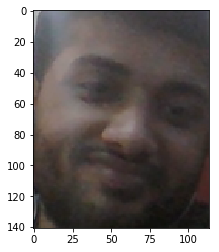

(160, 160)
1


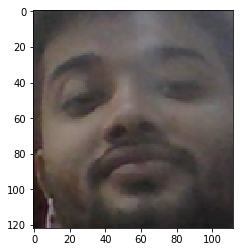

(160, 160)
2


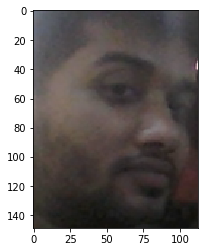

(160, 160)
3


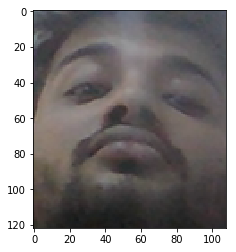

(160, 160)
4


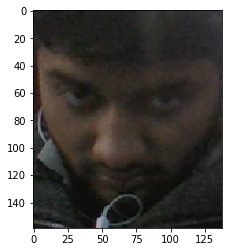

(160, 160)
5


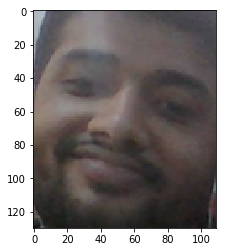

(160, 160)
6
Adding new training data for:  Sushil Ghimire ...
saved embeddings of  Sushil Ghimire  ....
Counter({'Sushil Ghimire': 6})
Escape hit, closing...


In [53]:
capture = cv2.VideoCapture(0)
cv2.namedWindow("test")
# cv2.namedWindow("test")
images = []
try:
    while (capture.isOpened()):
        ret, img = capture.read()
        img = cv2.flip(img, 1)
        if img is None:
            continue

        k = cv2.waitKey(1)

        if k%256 == 27:
#             ESC pressed
            print("Escape hit, closing...")
            break
            
#             T keyword pressed
        if k == ord('t'):
            print(train_classifier(user_name, images))

#             space pressed
        if k%256 == 32:
            plt.figure()
            plt.subplot()
            image  = Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
            face = get_faces(image)[0]
            coords = (face.x,face.y,face.x+face.w,face.y+face.h)
            image = image.crop(coords)
            plt.imshow(image)
            plt.show()
#             very very important resize to 160 by 160 before feeding it to network
            image = image.resize((160,160))
            print(image.size)
            images.append(image)
            print(len(images))
            
#         Initialize video writing
        cv2.imshow('face',img)
except Exception as  err:
    print(err.with_traceback())
    print('This is Error Occur !')
finally:
    images = []
    capture.release()
    cv2.destroyAllWindows()

### Face Recognition Using SVM classifier

In [78]:
capture = cv2.VideoCapture(0)
cv2.namedWindow("test")
with open(CLASSIFY_NAME, 'rb') as infile:
    (classifymodel, class_names) = pk.load(infile)
try:
    while (capture.isOpened()):
        t1 = cv2.getTickCount()
        ret, img = capture.read()
#         img = cv2.flip(img, 1)

        if img is None:
            continue

        k = cv2.waitKey(1)

        if k%256 == 27:
#             ESC pressed
            print("Escape hit, closing...")
            break
        
#         faces = get_faces(Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)))
        faces = get_faces(Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)))
        t2 = cv2.getTickCount()
        t = (t2 - t1) / cv2.getTickFrequency()
        fps = 1.0 / t
        cv2.putText(img, '{:.4f}'.format(t) + " " + '{:.3f}'.format(fps), (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (255, 0, 255), 2)
        
        for face in faces:
            tmp = Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
            tmp = tmp.crop((face.x,face.y,face.x+face.w,face.y+face.h)).resize((160,160))
            
            embvector = embedding(img_to_np(tmp))
            embvector = embvector.reshape(1, -1)
            predictions = classifymodel.predict_proba(embvector)
            print(predictions)
            best_class_indices = np.argmax(predictions, axis=1)
            tmp_lable=class_names[best_class_indices]
            best_class_probabilities = predictions[np.arange(len(best_class_indices)), best_class_indices]
            print(' Best class Probablity is ',best_class_probabilities)
            print(tmp_lable)
            if best_class_probabilities <= 0.56:
                tmp_lable=["others"]
            cv2.rectangle(img, (int(face.x), int(face.y)), (int(face.x+face.w), int(face.y+face.h)), (0,155,255), 2)
            cv2.putText(img, tmp_lable[0], (int(face.x), int(face.y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255), 2)
# #             print(face.data())
        cv2.imshow('face',img)
except Exception as  err:
    print(err.with_traceback())
    print('This is Error Occur !')
finally:
    images = []
    capture.release()
    cv2.destroyAllWindows()

[[0.2058217  0.07451763 0.15452802 0.56513265]]
 Best class Probablity is  [0.56513265]
['Sushil Ghimire']
[[0.22281738 0.1237437  0.18757557 0.46586336]]
 Best class Probablity is  [0.46586336]
['Sushil Ghimire']
[[0.23237581 0.11647279 0.13407514 0.51707626]]
 Best class Probablity is  [0.51707626]
['Sushil Ghimire']
[[0.16758195 0.18301902 0.10690343 0.5424956 ]]
 Best class Probablity is  [0.5424956]
['Sushil Ghimire']
[[0.18901681 0.17415833 0.1338218  0.50300306]]
 Best class Probablity is  [0.50300306]
['Sushil Ghimire']
[[0.19501767 0.15473824 0.14193235 0.50831175]]
 Best class Probablity is  [0.50831175]
['Sushil Ghimire']
[[0.19551484 0.14483939 0.15751534 0.50213043]]
 Best class Probablity is  [0.50213043]
['Sushil Ghimire']
[[0.172259   0.1458106  0.15682041 0.52510999]]
 Best class Probablity is  [0.52510999]
['Sushil Ghimire']
[[0.17764918 0.1528139  0.13193915 0.53759777]]
 Best class Probablity is  [0.53759777]
['Sushil Ghimire']
[[0.19290386 0.15007255 0.12268935 0.5

### your Face similarlity Probablity with Iron Man with SVM

In [77]:
capture = cv2.VideoCapture(0)
cv2.namedWindow("test")
with open(CLASSIFY_NAME, 'rb') as infile:
    (classifymodel, class_names) = pk.load(infile)
try:
    while (capture.isOpened()):
        t1 = cv2.getTickCount()
        ret, img = capture.read()
#         img = cv2.flip(img, 1)

        if img is None:
            continue

        k = cv2.waitKey(1)

        if k%256 == 27:
#             ESC pressed
            print("Escape hit, closing...")
            break
        
#         faces = get_faces(Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)))
        faces = get_faces(Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)))
        t2 = cv2.getTickCount()
        t = (t2 - t1) / cv2.getTickFrequency()
        fps = 1.0 / t
        cv2.putText(img, '{:.4f}'.format(t) + " " + '{:.3f}'.format(fps), (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (255, 0, 255), 2)
        
        for face in faces:
            tmp = Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
            tmp = tmp.crop((face.x,face.y,face.x+face.w,face.y+face.h)).resize((160,160))
            
            embvector = embedding(img_to_np(tmp))
            embvector = embvector.reshape(1, -1)
            predictions = classifymodel.predict_proba(embvector)
            iron_man_id = np.where(class_names=='Iron Man')
            print('Your face Similarlity with Iron man is :',)
            print(predictions[0][iron_man_id])
            best_class_indices = np.argmax(predictions, axis=1)
            tmp_lable=class_names[best_class_indices]
            best_class_probabilities = predictions[np.arange(len(best_class_indices)), best_class_indices]
#             print(' Best class Probablity is ',best_class_probabilities)
#             print(tmp_lable)
            if best_class_probabilities <= 0.56:
                tmp_lable=["others"]
            cv2.rectangle(img, (int(face.x), int(face.y)), (int(face.x+face.w), int(face.y+face.h)), (0,155,255), 2)
            cv2.putText(img, tmp_lable[0], (int(face.x), int(face.y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255), 2)
# #             print(face.data())
        cv2.imshow('face',img)
except Exception as  err:
    print(err.with_traceback())
    print('This is Error Occur !')
finally:
    images = []
    capture.release()
    cv2.destroyAllWindows()

Your face Similarlity with Iron man is :
[]
Your face Similarlity with Iron man is :
[]
Your face Similarlity with Iron man is :
[]
Your face Similarlity with Iron man is :
[]
Your face Similarlity with Iron man is :
[]
Your face Similarlity with Iron man is :
[]
Your face Similarlity with Iron man is :
[]
Your face Similarlity with Iron man is :
[]
Your face Similarlity with Iron man is :
[]
Your face Similarlity with Iron man is :
[]
Escape hit, closing...


### Face Recognization using SGD Classifier

In [78]:
capture = cv2.VideoCapture(0)

cv2.namedWindow("test")
with open(SGD_CLASSIFY, 'rb') as infile:
    (classifymodel, class_names) = pk.load(infile)
try:
    while (capture.isOpened()):
        t1 = cv2.getTickCount()
        ret, img = capture.read()
#         img = cv2.flip(img, 1)

        if img is None:
            continue

        k = cv2.waitKey(1)

        if k%256 == 27:
#             ESC pressed
            print("Escape hit, closing...")
            break
        
#         faces = get_faces(Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)))
        faces = get_faces(Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)))
        t2 = cv2.getTickCount()
        t = (t2 - t1) / cv2.getTickFrequency()
        fps = 1.0 / t
        cv2.putText(img, '{:.4f}'.format(t) + " " + '{:.3f}'.format(fps), (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (255, 0, 255), 2)
        
        for face in faces:
            tmp = Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
            tmp = tmp.crop((face.x,face.y,face.x+face.w,face.y+face.h)).resize((160,160))
            
            embvector = embedding(img_to_np(tmp))
            embvector = embvector.reshape(1, -1)
            predictions = classifymodel.predict_proba(embvector)
            best_class_indices = np.argmax(predictions, axis=1)
            tmp_lable=class_names[best_class_indices]
            best_class_probabilities = predictions[np.arange(len(best_class_indices)), best_class_indices]
            print(' Best class Probablity is ',best_class_probabilities)
            print(tmp_lable)
            if best_class_probabilities <= 0.58:
                tmp_lable=["others"]
            cv2.rectangle(img, (int(face.x), int(face.y)), (int(face.x+face.w), int(face.y+face.h)), (0,155,255), 2)
            cv2.putText(img, tmp_lable[0], (int(face.x), int(face.y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255), 2)
# #             print(face.data())
        cv2.imshow('face',img)
except Exception as  err:
    print(err.with_traceback())
    print('This is Error Occur !')
finally:
    images = []
    capture.release()
    cv2.destroyAllWindows()

 Best class Probablity is  [0.5887932]
['Sushil Ghimire']
 Best class Probablity is  [0.87556944]
['Sushil Ghimire']
 Best class Probablity is  [0.84741672]
['Sushil Ghimire']
 Best class Probablity is  [0.96262822]
['Sushil Ghimire']
 Best class Probablity is  [0.63754747]
['Sushil Ghimire']
 Best class Probablity is  [0.71638704]
['Sushil Ghimire']
Escape hit, closing...


### Face Similarlity percentage with some of the Celeb

In [77]:
capture = cv2.VideoCapture(0)
cv2.namedWindow("test")
with open(SGD_CLASSIFY, 'rb') as infile:
    (classifymodel, class_names) = pk.load(infile)
try:
    while (capture.isOpened()):
        t1 = cv2.getTickCount()
        ret, img = capture.read()
#         img = cv2.flip(img, 1)

        if img is None:
            continue

        k = cv2.waitKey(1)

        if k%256 == 27:
#             ESC pressed
            print("Escape hit, closing...")
            break
        
#         faces = get_faces(Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)))
        faces = get_faces(Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)))
        t2 = cv2.getTickCount()
        t = (t2 - t1) / cv2.getTickFrequency()
        fps = 1.0 / t
        cv2.putText(img, '{:.4f}'.format(t) + " " + '{:.3f}'.format(fps), (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (255, 0, 255), 2)
        
        for face in faces:
            tmp = Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
            tmp = tmp.crop((face.x,face.y,face.x+face.w,face.y+face.h)).resize((160,160))
            
            embvector = embedding(img_to_np(tmp))
            embvector = embvector.reshape(1, -1)
            predictions = classifymodel.predict_proba(embvector)
            iron_man_id = np.where(class_names=='Iron Man')
            print('Your face Similarlity with Iron man is :',)
            print(predictions[0][iron_man_id])
            best_class_indices = np.argmax(predictions, axis=1)
            tmp_lable=class_names[best_class_indices]
            best_class_probabilities = predictions[np.arange(len(best_class_indices)), best_class_indices]
#             print(' Best class Probablity is ',best_class_probabilities)
#             print(tmp_lable)
            if best_class_probabilities <= 0.56:
                tmp_lable=["others"]
            cv2.rectangle(img, (int(face.x), int(face.y)), (int(face.x+face.w), int(face.y+face.h)), (0,155,255), 2)
            cv2.putText(img, tmp_lable[0], (int(face.x), int(face.y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255), 2)
# #             print(face.data())
        cv2.imshow('face',img)
except Exception as  err:
    print(err.with_traceback())
    print('This is Error Occur !')
finally:
    images = []
    capture.release()
    cv2.destroyAllWindows()

Your face Similarlity with Iron man is :
[0.03262311]
Your face Similarlity with Iron man is :
[0.2427108]
Your face Similarlity with Iron man is :
[0.00770414]
Your face Similarlity with Iron man is :
[0.06325852]
Your face Similarlity with Iron man is :
[0.00014751]
Your face Similarlity with Iron man is :
[0.00101501]
Your face Similarlity with Iron man is :
[0.0042416]
Your face Similarlity with Iron man is :
[0.00485851]
Your face Similarlity with Iron man is :
[0.00028058]
Your face Similarlity with Iron man is :
[0.00278132]
Your face Similarlity with Iron man is :
[0.01448972]
Escape hit, closing...


### Using Gaussian Process Classifier to Recognize the face

In [115]:
tf.summary.FileWriter('./logdir',tf.get_default_graph())

### run load_embeddings only one times  during starting of kernel

In [48]:
load_embeddings()

Counter({'Aaditya': 28})
Counter({'Aaditya': 28, 'Anish Pandey': 16})


###  EXPERIMENTATION

###  EXPERIMENTATION with classfication

### Finding best parameter for Image Recognition

In [98]:
embeds, names = load_embeddings_for_SVC()
    
name_unique = np.unique(names)

#     label Encoder
labels = []
for i in range(len(names)):
        for j in range(len(name_unique)):
            if names[i]==name_unique[j]:
                labels.append(j)

#     Training classifier
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
             'random_state':[i for i in range(0,100,10)]}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X=embeds,y=labels)

print('Training classifier')
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Training classifier
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)


c:\users\welcome\envs\mltut\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Celeb Embeddings and Training

In [51]:
def celeb_save_embedding(result,name,emb='celeb_emb'):
    result = result
    if name+'_'+CLUSTER in os.listdir(os.path.join(os.getcwd(),emb)):
        with open(os.path.join(os.getcwd(),emb,name+'_'+CLUSTER),mode='rb') as fp:
            result =  np.concatenate((result,pk.load(fp)))
            print('saved embeddings of ',name,' ....')
        
    with open(os.path.join(os.getcwd(),emb,name+'_'+CLUSTER),mode='wb') as fp:
        pk.dump(result,fp)

In [61]:
def celeb_create_embeddings_from_dataset(path='celeb_dataset'):
    for filedir in os.listdir(os.path.join(os.getcwd(),path)):
        img = []
#         loop over list of faces to create embeddings
        for filename in os.listdir(os.path.join(os.getcwd(),path,filedir)):
            temp = Image.open(os.path.join(os.getcwd(),path,filedir,filename))
            face = get_faces(temp)[0]
            temp = temp.crop((face.x,face.y,face.x+face.w,face.y+face.h))
            temp = temp.resize((160,160))
            img.append(temp)
            
        num = len(img)
        X = np.zeros((num, EMBEDDING_SIZE), np.float32)
        for i, f in enumerate(img):
            X[i, :] = embedding(img_to_np(f))
            
        celeb_save_embedding(X,filedir)

In [63]:
celeb_create_embeddings_from_dataset()

In [64]:
def celeb_load_embeddings_for_classfication(path='celeb_emb') -> ('embeddings','labels'):
    X = []
    Y = []
    for filename  in os.listdir(os.path.join(os.getcwd(),path)):
        name = filename.split('_')[0]
        with open(os.path.join(os.getcwd(),path,filename),mode='rb') as fp:
            x = pk.load(fp)
            for emb in x:
                X.append(emb)
                Y.append(name)
    
    return X, Y

In [65]:
def celeb_classifyTrainSVC(path=None):
    embeds, names = celeb_load_embeddings_for_classfication()
    
    print(np.shape(embeds),len(names))
    
    name_unique = np.unique(names)
    
#     label Encoder
    labels = []
    for i in range(len(names)):
            for j in range(len(name_unique)):
                if names[i]==name_unique[j]:
                    labels.append(j)
                    
#     Training classifier
    print('Training classifier')
    model = SVC(kernel='linear', probability=True)
    model.fit(embeds, labels)
    with open('celeb/'+CLASSIFY_NAME, 'wb') as outfile:
        pk.dump((model,name_unique), outfile)
        print('Saved classifier model to file "%s"' % CLASSIFY_NAME)

In [68]:
# SGD Classifier
def celeb_classifyTrainSGD(path=None):
    embeds, names = celeb_load_embeddings_for_classfication()
    
    print(np.shape(embeds),len(names))
    
    name_unique = np.unique(names)
    
#     label Encoder
    labels = []
    for i in range(len(names)):
            for j in range(len(name_unique)):
                if names[i]==name_unique[j]:
                    labels.append(j)
                    
#     Training classifier
    print('Training classifier')
    model = SGDClassifier(loss='log')
    model.fit(embeds,labels)
    if path == None:
        path=''
    with open(os.path.join(os.getcwd(),'celeb',SGD_CLASSIFY), 'wb') as outfile:
        pk.dump((model,name_unique), outfile)
        print('Saved classifier model to file "%s"' % SGD_CLASSIFY)

In [69]:
celeb_classifyTrainSGD()
celeb_classifyTrainSVC()

(17, 512) 17
Training classifier
Saved classifier model to file "SGD.CLASS"
(17, 512) 17
Training classifier
Saved classifier model to file "SVM.SVC"


c:\users\welcome\envs\mltut\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [74]:
capture = cv2.VideoCapture(0)
cv2.namedWindow("test")
with open(os.path.join('celeb',SGD_CLASSIFY), 'rb') as infile:
    (classifymodel, class_names) = pk.load(infile)
try:
    while (capture.isOpened()):
        t1 = cv2.getTickCount()
        ret, img = capture.read()
#         img = cv2.flip(img, 1)

        if img is None:
            continue

        k = cv2.waitKey(1)

        if k%256 == 27:
#             ESC pressed
            print("Escape hit, closing...")
            break
        
#         faces = get_faces(Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)))
        faces = get_faces(Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)))
        t2 = cv2.getTickCount()
        t = (t2 - t1) / cv2.getTickFrequency()
        fps = 1.0 / t
        cv2.putText(img, '{:.4f}'.format(t) + " " + '{:.3f}'.format(fps), (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (255, 0, 255), 2)
        
        for face in faces:
            tmp = Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
            tmp = tmp.crop((face.x,face.y,face.x+face.w,face.y+face.h)).resize((160,160))
            
            embvector = embedding(img_to_np(tmp))
            embvector = embvector.reshape(1, -1)
            predictions = classifymodel.predict_proba(embvector)
            print(predictions)
            print(class_names)
            best_class_indices = np.argmax(predictions, axis=1)
            tmp_lable=class_names[best_class_indices]
            best_class_probabilities = predictions[np.arange(len(best_class_indices)), best_class_indices]
            if best_class_probabilities <= 0.66:
                tmp_lable=["others"]
            cv2.rectangle(img, (int(face.x), int(face.y)), (int(face.x+face.w), int(face.y+face.h)), (0,155,255), 2)
            cv2.putText(img, tmp_lable[0], (int(face.x), int(face.y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255), 2)
# #             print(face.data())
        cv2.imshow('face',img)
except Exception as  err:
    print(err.with_traceback())
    print('This is Error Occur !')
finally:
    images = []
    capture.release()
    cv2.destroyAllWindows()

[[4.56794019e-01 6.24672699e-04 5.42246562e-01 3.34746629e-04]]
['Doctor Strange' 'Joker' 'Rajesh Dai' 'The Flash']
[[4.68998647e-01 2.66689516e-05 5.30956867e-01 1.78168562e-05]]
['Doctor Strange' 'Joker' 'Rajesh Dai' 'The Flash']
[[0.65059881 0.00151512 0.33509478 0.01279128]]
['Doctor Strange' 'Joker' 'Rajesh Dai' 'The Flash']
[[4.85755760e-01 7.42730143e-05 5.14098296e-01 7.16704413e-05]]
['Doctor Strange' 'Joker' 'Rajesh Dai' 'The Flash']
[[6.68478485e-01 2.22802174e-03 3.29049049e-01 2.44444293e-04]]
['Doctor Strange' 'Joker' 'Rajesh Dai' 'The Flash']
[[5.17090036e-01 2.86099334e-03 4.79982940e-01 6.60307407e-05]]
['Doctor Strange' 'Joker' 'Rajesh Dai' 'The Flash']
[[0.84597706 0.00205393 0.14821341 0.0037556 ]]
['Doctor Strange' 'Joker' 'Rajesh Dai' 'The Flash']
[[4.55508355e-01 2.73178999e-04 5.44189808e-01 2.86587806e-05]]
['Doctor Strange' 'Joker' 'Rajesh Dai' 'The Flash']
[[0.68741275 0.01352044 0.18937106 0.10969574]]
['Doctor Strange' 'Joker' 'Rajesh Dai' 'The Flash']
[[4.